In [77]:
# Step 1

import pandas as pd
from gurobipy import Model, GRB, quicksum

df = pd.read_csv("/Users/roblegure/Downloads/data.csv")
df.head()

# Extracting name column into a list
I = df["name"].tolist()

# Time slots with slot size 0.5 representing 30 minutes
slot_size = 0.5
T = [
    0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5,
    4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5,
    8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5,
    12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5,
    16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5,
    20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5,
    24.0
]

# Create a dictonary mapping each student to the earliest time that they can start laundry
start_time = {}
for _, row in df.iterrows():
    start_time[row["name"]] = row["start_time"]

# To start initialize every student to have an empty dictionary, 
# then loop through each students row looking for their start time and end time. 
# Through the for loop fill each students row by seeing if t (time) is inside their window
availability = {i: {} for i in I}
for _, row in df.iterrows():
    name = row["name"]
    start = row["start_time"]
    end = row["end_time"]
    for t in T:
        availability[name][t] = 1 if start <= t <= end else 0

# Washer and dryer names used for the model
washers = ["W1","W2","W3","W4"]
dryers = ["D1","D2","D3","D4"]

In [71]:
# Step 2

# Initialize a Gurobi model which will contain everything
m = Model("LaundryScheduling")

In [72]:
# Step 3 (Decision variables)

# W[i, j, t] = 1  -> student i is assigned to wash on machine j at time t
# W[i, j, t] = 0  -> otherwise
# Goal is to loop over all of the students, washing machines, and time slots and create every possible choice so that the optimizer
# can choose the best combo for each student 
W = {}
for i in I:
    for j in washers:
        for t in T:
            W[i,j,t] = m.addVar(vtype=GRB.BINARY, name=f"W[{i},{j},{t}]")

# D[i, j, t] = 1  -> student i is assigned to use dryer j at time t
# D[i, j, t] = 0  -> otherwise
# Goal is to loop over all of the students, dryers, and time slots and create every possible choice so that the optimizer
# can choose the best combo for each student 
D = {}
for i in I:
    for j in dryers:
        for t in T:
            D[i,j,t] = m.addVar(vtype=GRB.BINARY, name=f"D[{i},{j},{t}]")

# Delay is used to measure how long it takes for a student has to wait to get a washer also enforce fairness
delay = {}
for i in I:
    delay[i] = m.addVar(vtype=GRB.CONTINUOUS, name=f"delay[{i}]")

# Max delay makes sure that the schedule enforces the fairness by reducing the largest delay
D_max = m.addVar(vtype=GRB.CONTINUOUS, name="D_max")

In [73]:
# Step 4 (Assigned Times)

# Assigned wash and dry times for each student
assigned_time = {}
assigned_dry_time = {}

# For both the quicksum picks out the single time W[i,j,t] = 1 and D[i,j,t] = 1 and that becomes the 
# students assigned wash and dry time
for i in I:
    assigned_time[i] = quicksum(t * W[i,j,t] for j in washers for t in T)
    assigned_dry_time[i] = quicksum(t * D[i,j,t] for j in dryers for t in T)

In [74]:
# Step 5 (Constraints)

# Each student gets exactly 1 wash and 1 dry slot
for i in I:
    m.addConstr(quicksum(W[i,j,t] for j in washers for t in T) == 1, name=f"OneWash[{i}]")
    m.addConstr(quicksum(D[i,j,t] for j in dryers  for t in T) == 1, name=f"OneDry[{i}]")

# At most one student can use a washer and dryer at the same time
for j in washers:
    for t in T:
        m.addConstr(quicksum(W[i,j,t] for i in I) <= 1, name=f"WasherCap[{j},{t}]")

for j in dryers:
    for t in T:
        m.addConstr(quicksum(D[i,j,t] for i in I) <= 1, name=f"DryerCap[{j},{t}]")

# If a student isn't available at t (time) then the cannot wash or dry at t
for i in I:
    for t in T:
        if availability[i][t] == 0:
            m.addConstr(quicksum(W[i,j,t] for j in washers) == 0, name=f"NoWash[{i},{t}]")
            m.addConstr(quicksum(D[i,j,t] for j in dryers) == 0, name=f"NoDry[{i},{t}]")

# Drying must occur after washing
for i in I:
    m.addConstr(assigned_dry_time[i] >= assigned_time[i] + 0.5, name=f"DryAfterWash[{i}]")

# A student cannot wash and dry at the same time slot
for i in I:
    for t in T:
        for j_w in washers:
            for j_d in dryers:
                m.addConstr(D[i,j_d,t] + W[i,j_w,t] <= 1, name=f"NoSameSlot[{i},{t},{j_w},{j_d}]")

# Calculates how far the students actual wash time is from their preferred wash time
for i in I:
    m.addConstr(delay[i] >= assigned_time[i] - start_time[i], name=f"DelayDef1[{i}]")
    m.addConstr(delay[i] >= 0, name=f"DelayNonNeg[{i}]")
    m.addConstr(D_max >= delay[i], name=f"MaxDelay[{i}]")

In [75]:
# Step 6 (Objective function)

m.setObjective(D_max, GRB.MINIMIZE)


# Step 7 (Gurobi solver)

m.optimize()


# Step 8 (Print schedule)

if m.status == GRB.OPTIMAL:
    print("\nLaundry Schedule:")
    print("Student | WashMachine | WashTime | DryMachine | DryTime | Delay")
    print("--------+------------+----------+-----------+---------+-------")

    for i in I:
        
        wash_assign = [(j,t) for j in washers for t in T if W[i,j,t].x > 0.5]
        dry_assign  = [(j,t) for j in dryers  for t in T if D[i,j,t].x > 0.5]

        if wash_assign:
            w_j, w_t = wash_assign[0]
        else:
            w_j, w_t = None, None

        if dry_assign:
            d_j, d_t = dry_assign[0]
        else:
            d_j, d_t = None, None

        print(f"{i:8} | {w_j:10} | {w_t:8} | {d_j:9} | {d_t:7} | {delay[i].x:5.2f}")

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 47022 rows, 21616 columns and 173980 nonzeros
Model fingerprint: 0x9a35a68b
Variable types: 56 continuous, 21560 integer (21560 binary)
Coefficient statistics:
  Matrix range     [5e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 2e+01]
Presolve removed 45423 rows and 13215 columns
Presolve time: 0.08s
Presolved: 1599 rows, 8401 columns, 36755 nonzeros
Variable types: 0 continuous, 8401 integer (8400 binary)
Found heuristic solution: objective 11.5000000

Root relaxation: objective 1.666667e-01, 313 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.16667    0   24   1

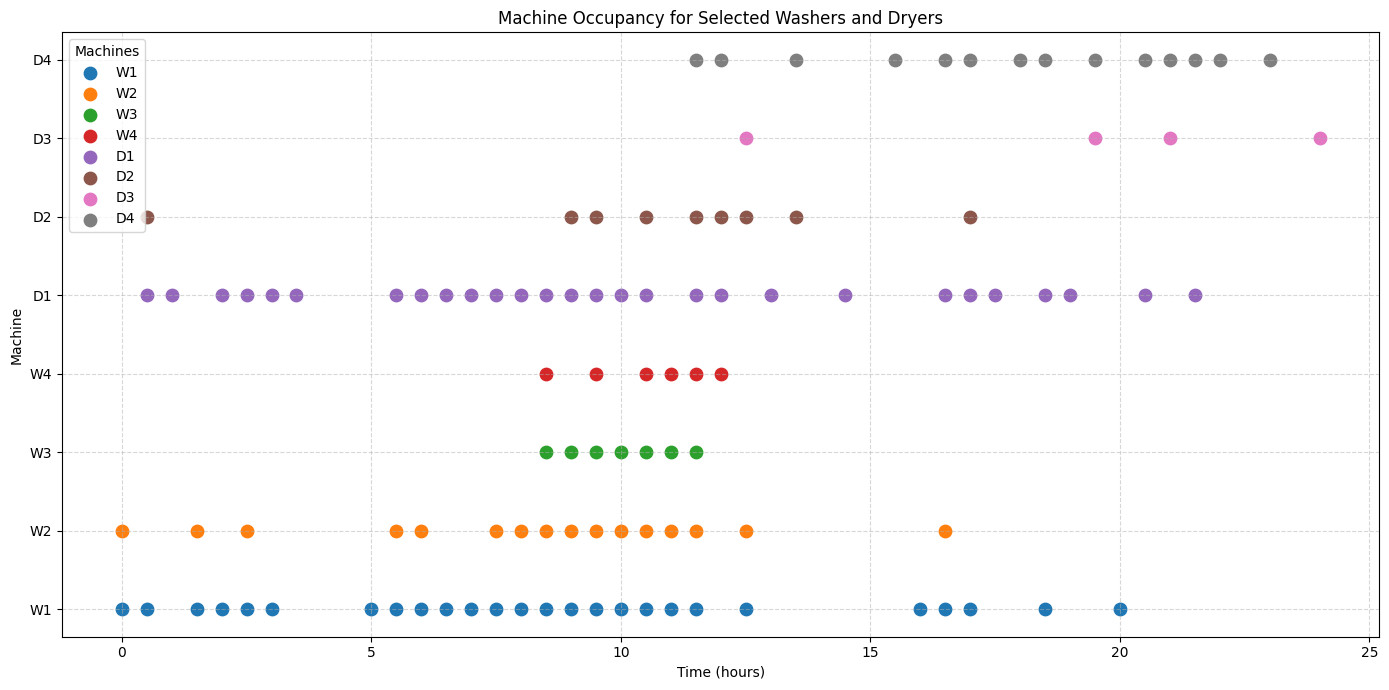

In [76]:
import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd

text = """Student,WashMachine,WashTime,DryMachine,DryTime,Delay
Luke,W2,1.5,D4,12.0,0.50
Roble,W2,0.0,D2,0.5,0.50
Kayla,W1,17.0,D1,17.5,0.50
George,W4,12.0,D4,20.5,0.50
Cleveland,W2,8.0,D2,12.5,0.50
Cliff,W2,6.0,D4,18.0,0.50
Clifford,W3,11.0,D1,18.5,0.50
Clifton,W3,8.5,D1,21.5,0.50
Clint,W1,20.0,D1,20.5,0.50
Clinten,W2,8.5,D4,15.5,0.50
Clinton,W4,11.5,D4,16.5,0.50
Clive,W3,9.0,D3,21.0,0.50
Clyde,W1,3.0,D1,3.5,0.50
Cob,W1,16.0,D1,16.5,0.50
Cobb,W3,10.0,D2,10.5,0.50
Cobbie,W2,10.0,D4,13.5,0.50
Cobby,W3,9.5,D4,22.0,0.50
Cody,W1,0.5,D1,1.0,0.50
Colbert,W2,16.5,D4,19.5,0.50
Cole,W1,5.0,D1,5.5,0.50
Coleman,W2,7.5,D1,8.0,0.50
Colin,W2,10.5,D2,17.0,0.50
Collin,W2,12.5,D3,19.5,0.50
Collins,W4,8.5,D2,9.0,0.50
Conan,W1,11.5,D4,21.0,0.50
Connie,W1,6.0,D1,6.5,0.50
Connolly,W1,7.5,D2,9.5,0.50
Connor,W1,7.0,D1,7.5,0.50
Conrad,W2,9.0,D2,13.5,0.50
Conroy,W4,10.5,D3,24.0,0.50
Constantin,W4,11.0,D4,11.5,0.50
Constantine,W2,9.5,D3,12.5,0.50
Holly,W1,0.0,D1,0.5,0.50
Holly-Anne,W1,9.0,D1,9.5,0.50
Hollyanne,W1,10.5,D2,11.5,0.50
Honey,W2,5.5,D4,21.5,0.50
Honor,W1,16.5,D1,17.0,0.50
Honoria,W1,2.0,D1,2.5,0.50
Hope,W1,9.5,D4,18.5,0.50
Horatia,W4,9.5,D1,10.0,0.50
Hortense,W2,11.0,D1,14.5,0.50
Hortensia,W1,11.0,D1,11.5,0.50
Hulda,W1,18.5,D1,19.0,0.50
Hyacinth,W1,6.5,D1,7.0,0.50
Hyacintha,W1,1.5,D1,2.0,0.50
Hyacinthe,W1,5.5,D1,6.0,0.50
Hyacinthia,W2,2.5,D4,17.0,0.50
Hyacinthie,W1,8.5,D1,9.0,0.50
Hynda,W3,11.5,D2,12.0,0.50
Ianthe,W1,8.0,D1,8.5,0.50
Ibbie,W1,10.0,D1,10.5,0.50
Ibby,W1,2.5,D1,3.0,0.50
Ida,W1,12.5,D1,13.0,0.50
Idalia,W2,11.5,D1,12.0,0.50
Idalina,W3,10.5,D4,23.0,0.50
"""

df = pd.read_csv(StringIO(text))

washers = ["W1", "W2", "W3", "W4"]
dryers = ["D1", "D2", "D3", "D4"]

machine_data = {}

for machine in washers + dryers:
    if machine.startswith("W"):  
        times = df[df["WashMachine"] == machine]["WashTime"]
    else:  
        times = df[df["DryMachine"] == machine]["DryTime"]
    machine_data[machine] = times.tolist()

plt.figure(figsize=(14, 7))

for machine, times in machine_data.items():
    plt.scatter(times, [machine] * len(times), s=80, label=machine)

plt.xlabel("Time (hours)")
plt.ylabel("Machine")
plt.title("Machine Occupancy for Selected Washers and Dryers")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Machines")
plt.tight_layout()

plt.show()